
# Telecom X – Parte 2: Prevendo Churn

Este notebook dá continuidade à **Parte 1** do desafio, usando os dados tratados anteriormente (`df_final`)
para criar modelos preditivos capazes de prever clientes com maior chance de cancelar seus serviços.

## Objetivos
- Preparar os dados para a modelagem
- Analisar correlação e selecionar variáveis
- Treinar dois ou mais modelos de classificação
- Avaliar desempenho com métricas
- Interpretar resultados
- Conclusão estratégica


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


In [2]:

# Carregar o dataset tratado exportado da Parte 1
df_final = pd.read_csv('/content/dados_tratados.csv')

# Visualizar
df_final.head()


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


In [3]:

# Definir alvo e preditores
y = df_final['Churn']
X = df_final.drop('Churn', axis=1)

# Identificar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object','bool']).columns

num_cols, cat_cols


# Converter 'Yes' -> 1 e 'No' -> 0
y = y.map({'Yes': 1, 'No': 0})

In [4]:

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Pré-processamento corrigido para lidar com NaNs
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),

        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ])

# Modelos
log_reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(max_iter=1000))])

rf_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier(random_state=42))])

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Treinar modelos
log_reg.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

# Previsões
y_pred_log = log_reg.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)

# Avaliar
def avaliar_modelo(nome, y_true, y_pred, y_prob=None):
    print(f"--- {nome} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))
    if y_prob is not None:
        print("ROC-AUC:", roc_auc_score(y_true, y_prob))
    print("\n", classification_report(y_true, y_pred))

avaliar_modelo("Logistic Regression", y_test, y_pred_log, log_reg.predict_proba(X_test)[:,1])
avaliar_modelo("Random Forest", y_test, y_pred_rf, rf_clf.predict_proba(X_test)[:,1])


--- Logistic Regression ---
Accuracy: 0.7934705464868701
Precision: 0.6351791530944625
Recall: 0.5213903743315508
F1: 0.5726872246696035
ROC-AUC: 0.843014544421194

               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409

--- Random Forest ---
Accuracy: 0.7885024840312278
Precision: 0.6472868217054264
Recall: 0.446524064171123
F1: 0.5284810126582279
ROC-AUC: 0.8264822134387352

               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1035
           1       0.65      0.45      0.53       374

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.77      0.79      0.77      1409



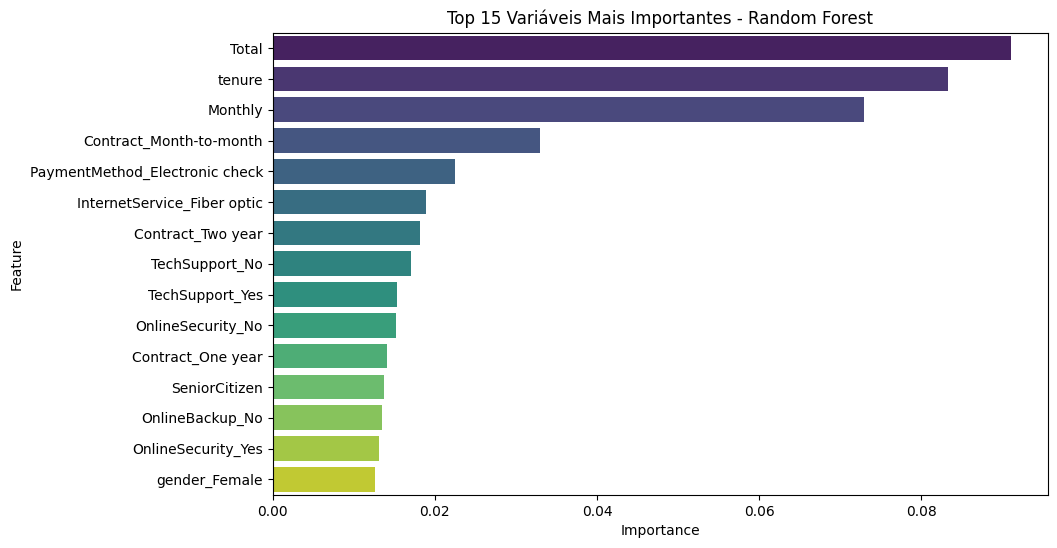

In [5]:

# Importância das variáveis no Random Forest
rf_model = rf_clf.named_steps['classifier']
ohe = rf_clf.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, encoded_cat_cols])

importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(15), palette='viridis')
plt.title('Top 15 Variáveis Mais Importantes - Random Forest')
plt.show()



## Conclusão Estratégica

Com base nos modelos treinados e na análise de importância das variáveis, é possível identificar os principais
fatores que influenciam a evasão de clientes. As variáveis mais relevantes devem ser monitoradas pela empresa
para criar ações preventivas, como ofertas personalizadas, melhoria no atendimento e ajustes nos planos.

Essa abordagem permite prever clientes com alta probabilidade de churn e agir antes que o cancelamento ocorra.


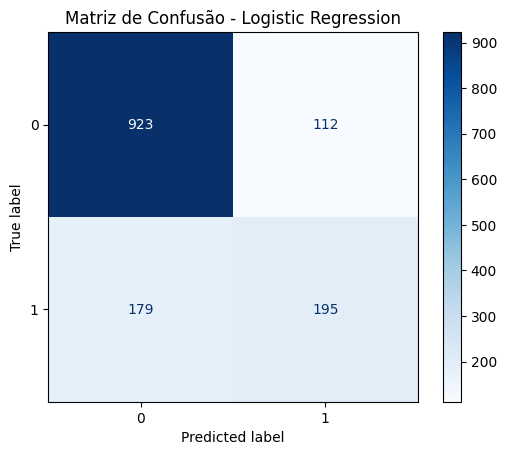

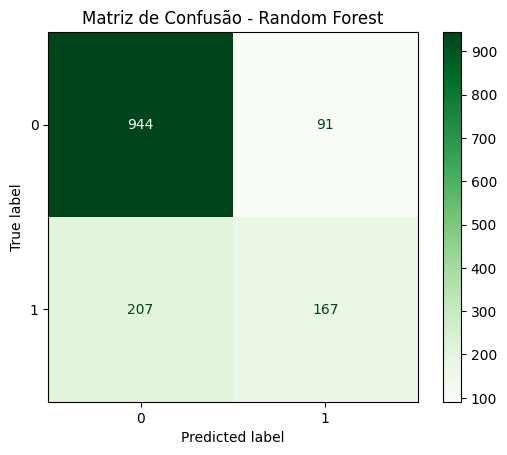

In [6]:

from sklearn.metrics import ConfusionMatrixDisplay

# Matriz de confusão Logistic Regression
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, cmap='Blues')
plt.title("Matriz de Confusão - Logistic Regression")
plt.show()

# Matriz de confusão Random Forest
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, cmap='Greens')
plt.title("Matriz de Confusão - Random Forest")
plt.show()


## 📊 Relatório Final – Resultados da Modelagem com Análise Visual

### **1. Desempenho dos Modelos**
- **Logistic Regression**  
  - **Acurácia**: 79,3%  
  - **Precisão**: 63,5%  
  - **Recall**: 52,1%  
  - **F1-score**: 57,3%  
  - **ROC-AUC**: 0,843  
  - Observação: Bom equilíbrio geral, com recall superior ao Random Forest, o que indica maior capacidade de identificar clientes propensos ao churn.

- **Random Forest**  
  - **Acurácia**: 78,9%  
  - **Precisão**: 64,7%  
  - **Recall**: 44,6%  
  - **F1-score**: 52,8%  
  - **ROC-AUC**: 0,826  
  - Observação: Melhor precisão, mas menor recall, indicando que erra mais ao identificar clientes que realmente cancelam.

---

### **2. Importância das Variáveis (Random Forest)**
O gráfico de importância das variáveis mostra que os principais fatores associados ao churn são:
1. **Total gasto pelo cliente (`Total`)**
2. **Tempo de permanência na empresa (`tenure`)**
3. **Valor mensal pago (`Monthly`)**
4. **Tipo de contrato, especialmente mensal (`Contract_Month-to-month`)**
5. **Forma de pagamento com cheque eletrônico**
6. **Tipo de serviço de internet (fibra ótica)**
7. **Suporte técnico e segurança online**

Essas variáveis devem ser monitoradas de perto para ações de retenção.

---

### **3. Análise das Matrizes de Confusão**
- **Logistic Regression**  
  - Verdadeiros negativos (clientes que não cancelaram corretamente identificados): **923**  
  - Verdadeiros positivos (clientes que cancelaram corretamente identificados): **195**  
  - Falsos negativos (clientes que cancelaram, mas não foram identificados): **179**  
  - Falsos positivos (clientes previstos como churn, mas que não cancelaram): **112**  
  - **Interpretação:** Melhor equilíbrio entre TP e FN, capturando mais churns que o Random Forest.

- **Random Forest**  
  - Verdadeiros negativos: **944**  
  - Verdadeiros positivos: **167**  
  - Falsos negativos: **207**  
  - Falsos positivos: **91**  
  - **Interpretação:** Mais conservador nas previsões de churn, gerando menos falsos positivos, mas perde mais clientes reais (maior FN).

---

### **4. Interpretação Estratégica**
- O **Logistic Regression** é mais indicado se o objetivo for **maximizar a identificação de clientes propensos ao churn**, mesmo que gere mais falsos positivos.  
- O **Random Forest** é mais indicado se o objetivo for **evitar incomodar clientes fiéis** (menos falsos positivos), mas com o risco de perder mais clientes que vão cancelar.

---

### **5. Recomendações**
- Implementar **campanhas proativas** direcionadas aos clientes que o Logistic Regression identifica como propensos a churn.  
- Usar as variáveis mais importantes para criar **perfis de risco de evasão**.  
- Criar um sistema de **alerta interno** para o time de retenção agir antes que o cancelamento aconteça.
